# Regression Project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv(r'C:\Users\Przem\Desktop\MachineLearning\DummyMarketing_Data\Dummy Data HSS.csv')

TV promotion budget (in million)  
Social Media promotion budget (in million)  
Radio promotion budget (in million)  
Influencer: Whether the promotion collaborate with Mega, Macro, Nano, Micro influencer  
Sales (in million)

In [3]:
df.head()

,TV,Radio,Social Media,Influencer,Sales
0,16.0,6.566231,2.907983,Mega,54.732757
1,13.0,9.237765,2.409567,Mega,46.677897
2,41.0,15.886446,2.913410,Mega,150.177829
3,83.0,30.020028,6.922304,Mega,298.246340
4,15.0,8.437408,1.405998,Micro,56.594181


In [4]:
df.shape

(4572, 5)

## Feature engineering

### Missing Data

In [5]:
df.isna().sum()

TV              10
Radio            4
Social Media     6
Influencer       0
Sales            6
dtype: int64

In [6]:
df.isna().sum()/len(df)*100

TV              0.218723
Radio           0.087489
Social Media    0.131234
Influencer      0.000000
Sales           0.131234
dtype: float64

Brakujące wartości stanowią znikomy odsetek moich danych, więc mogę je poprostu usunąć.

In [7]:
df = df.dropna()

### Outliers

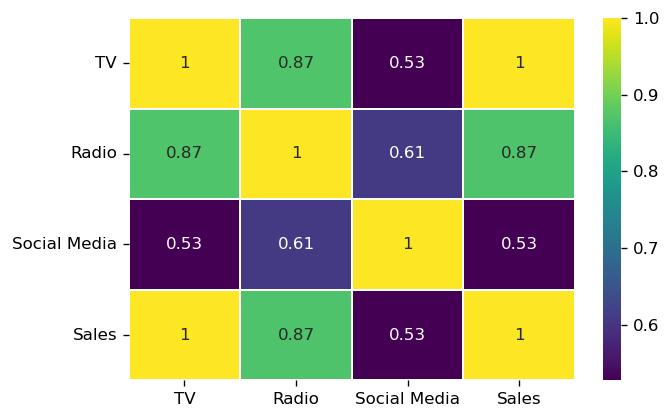

In [8]:
plt.figure(dpi=120)
sns.heatmap(df.corr(), annot=True, linewidth=1, cmap='viridis')
plt.yticks(rotation=0)
plt.show()

<Figure size 660x440 with 0 Axes>

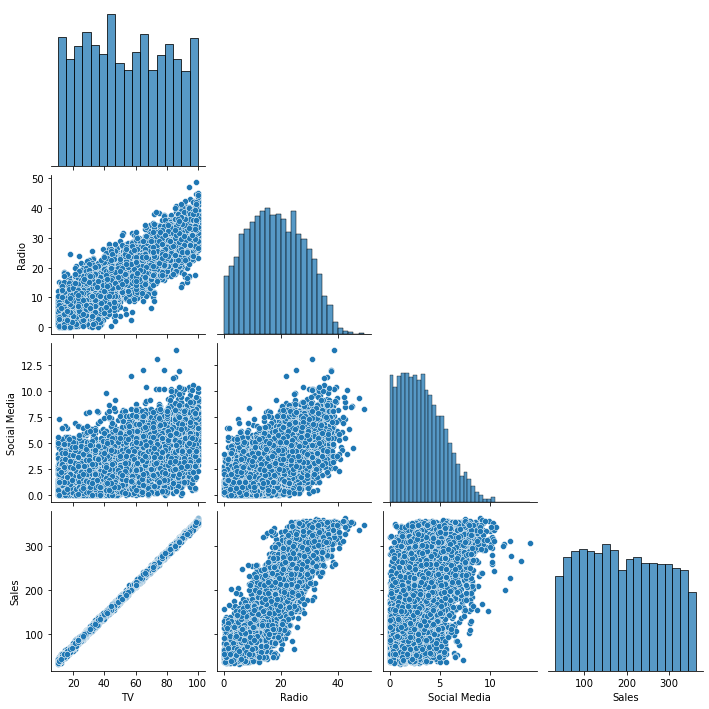

In [9]:
plt.figure(dpi=110)
sns.pairplot(df, corner=True)
plt.show()

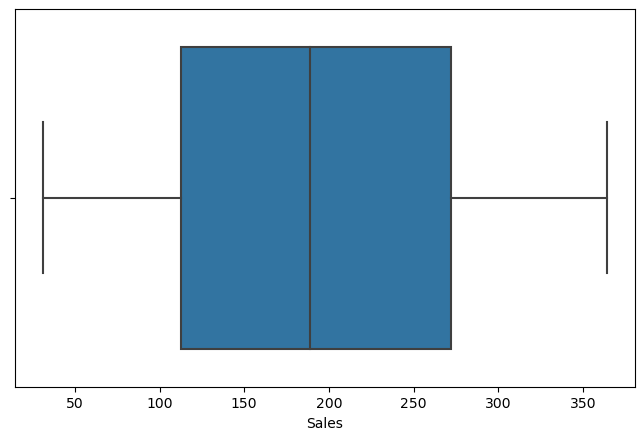

In [10]:
plt.figure(dpi=100, figsize=(8,5))
sns.boxplot(data=df, x='Sales')
plt.show()

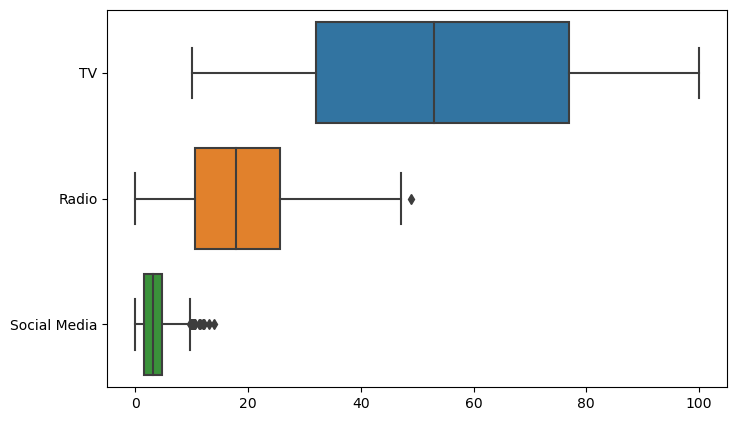

In [11]:
plt.figure(dpi=100, figsize=(8,5))
sns.boxplot(data=df.drop(columns='Sales'), orient='h')
plt.show()

Jak widać na wykresie pudełkowym, w naszym występuje jedna obserwacja odstająca dla zmiennej Radio oraz sporo obserwacji odstających dla zmiennej Social Media.

Najpierw pozbędę się obserwacji odstającje dla zmiennej Radio

In [12]:
describeRadio = df['Radio'].describe()
describeRadio

count    4546.000000
mean       18.157533
std         9.663260
min         0.000684
25%        10.555355
50%        17.859513
75%        25.640603
max        48.871161
Name: Radio, dtype: float64

In [13]:
IQR_radio = describeRadio.loc['75%'] - describeRadio.loc['25%']
lower_limit_radio = describeRadio.loc['25%'] - 1.5*IQR_radio
upper_limit_radio = describeRadio.loc['75%'] + 1.5*IQR_radio
print(f'IQR = {IQR_radio}')
print(f'lower_limit = {lower_limit_radio}')
print(f'upper_limit = {upper_limit_radio}')

IQR = 15.085248102500003
lower_limit = -12.072516916250006
upper_limit = 48.26847549375


In [14]:
df = df[df['Radio'] < upper_limit_radio]

Obserwacja z wartością odstającą dla zmiennej radio została usunięta ze zbioru danych.

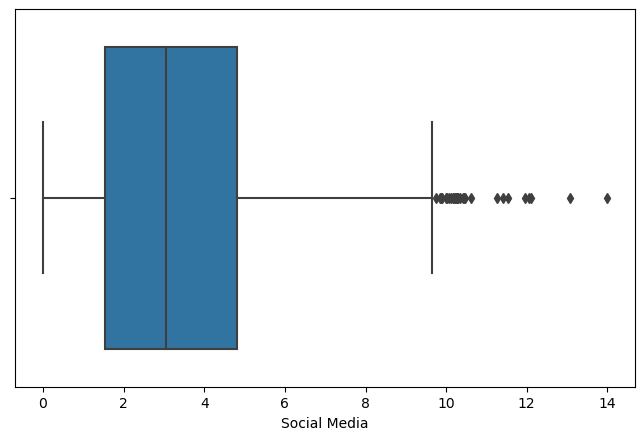

In [15]:
plt.figure(dpi=100, figsize=(8,5))
sns.boxplot(data=df, x='Social Media')
plt.show()

In [16]:
describeSocial = df['Social Media'].describe()
describeSocial

count    4545.000000
mean        3.322380
std         2.210268
min         0.000031
25%         1.530349
50%         3.055372
75%         4.803605
max        13.981662
Name: Social Media, dtype: float64

In [17]:
IQR_social = describeSocial.loc['75%'] - describeSocial.loc['25%']
lower_limit_social = describeSocial.loc['25%'] - 1.5*IQR_social
upper_limit_social = describeSocial.loc['75%'] + 1.5*IQR_social
print(f'IQR = {IQR_social}')
print(f'lower_limit = {lower_limit_social}')
print(f'upper_limit = {upper_limit_social}')

IQR = 3.2732564039999996
lower_limit = -3.3795359939999994
upper_limit = 9.713489621999999


In [18]:
df[df['Social Media'] > upper_limit_social].shape[0]/df.shape[0]*100

0.6160616061606161

Oberwacje odstające dla zmiennej Social Media stanowią mniej niż 1% wszystkich obesrwacji, więc również zdecydowałem się je usunąć.

In [19]:
df = df[df['Social Media'] < upper_limit_social]

In [20]:
df.shape

(4517, 5)

### Categorical Data - Encoding

In [21]:
df['Influencer'].unique()

array(['Mega', 'Micro', 'Nano', 'Macro'], dtype=object)

Zmienna Influencer posiada 4 unikalne wartości. Są to wartości, które można ustawić według pewnej hierarchi (od Nano do Mega influencer'a). Postanowiłem więc zakodować ja za pomocą liczb 1,2,3,4.

In [22]:
myMap = {'Nano': 1, 'Micro': 2, 'Macro': 3, 'Mega': 4}

In [23]:
df['Influencer'] = df['Influencer'].map(myMap)

In [24]:
df.head()

,TV,Radio,Social Media,Influencer,Sales
0,16.0,6.566231,2.907983,4,54.732757
1,13.0,9.237765,2.409567,4,46.677897
2,41.0,15.886446,2.913410,4,150.177829
3,83.0,30.020028,6.922304,4,298.246340
4,15.0,8.437408,1.405998,2,56.594181


## Train Test Split and Data Standarization

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X = df.drop(columns='Sales')

In [27]:
y = df['Sales']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
scaler = StandardScaler()

In [30]:
scaler.fit(X_train)

StandardScaler()

In [31]:
X_train = scaler.transform(X_train)

In [32]:
X_test = scaler.transform(X_test)

## SVR model

### GridSearchCV

In [33]:
from sklearn.svm import SVR

In [34]:
svr_model = SVR()

In [35]:
svr_param = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
             'C': [0.01, 0.05, 0.1, 0.25, 0.5, 1, 2, 3, 5, 6, 7, 8, 10, 15]}

In [36]:
svr_GridSearch_model = GridSearchCV(svr_model,
                                    svr_param,
                                    scoring='neg_mean_squared_error',
                                    cv = 5,
                                    verbose=3)

In [37]:
svr_GridSearch_model.fit(X_train, y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV 1/5] END .........C=0.01, kernel=linear;, score=-2504.616 total time=   1.1s
[CV 2/5] END .........C=0.01, kernel=linear;, score=-2370.947 total time=   1.1s
[CV 3/5] END .........C=0.01, kernel=linear;, score=-2517.582 total time=   1.1s
[CV 4/5] END .........C=0.01, kernel=linear;, score=-2330.786 total time=   1.1s
[CV 5/5] END .........C=0.01, kernel=linear;, score=-2434.770 total time=   1.1s
[CV 1/5] END ...........C=0.01, kernel=poly;, score=-6106.332 total time=   1.2s
[CV 2/5] END ...........C=0.01, kernel=poly;, score=-5829.008 total time=   1.2s
[CV 3/5] END ...........C=0.01, kernel=poly;, score=-6099.717 total time=   1.0s
[CV 4/5] END ...........C=0.01, kernel=poly;, score=-5759.684 total time=   1.1s
[CV 5/5] END ...........C=0.01, kernel=poly;, score=-5933.942 total time=   1.0s
[CV 1/5] END ............C=0.01, kernel=rbf;, score=-7976.185 total time=   1.9s
[CV 2/5] END ............C=0.01, kernel=rbf;, s

[CV 2/5] END ...............C=1, kernel=linear;, score=-8.835 total time=   1.1s
[CV 3/5] END ...............C=1, kernel=linear;, score=-8.083 total time=   1.3s
[CV 4/5] END ...............C=1, kernel=linear;, score=-8.717 total time=   1.2s
[CV 5/5] END ...............C=1, kernel=linear;, score=-8.938 total time=   1.2s
[CV 1/5] END ..............C=1, kernel=poly;, score=-1341.955 total time=   1.2s
[CV 2/5] END ..............C=1, kernel=poly;, score=-1436.089 total time=   1.1s
[CV 3/5] END ..............C=1, kernel=poly;, score=-1262.968 total time=   1.2s
[CV 4/5] END ..............C=1, kernel=poly;, score=-1229.810 total time=   1.1s
[CV 5/5] END ..............C=1, kernel=poly;, score=-1348.671 total time=   1.1s
[CV 1/5] END ................C=1, kernel=rbf;, score=-249.159 total time=   1.9s
[CV 2/5] END ................C=1, kernel=rbf;, score=-308.587 total time=   2.0s
[CV 3/5] END ................C=1, kernel=rbf;, score=-241.077 total time=   1.9s
[CV 4/5] END ...............

[CV 4/5] END ...............C=7, kernel=linear;, score=-8.712 total time=   1.5s
[CV 5/5] END ...............C=7, kernel=linear;, score=-8.830 total time=   1.4s
[CV 1/5] END ..............C=7, kernel=poly;, score=-1144.522 total time=   1.3s
[CV 2/5] END ..............C=7, kernel=poly;, score=-1313.429 total time=   1.1s
[CV 3/5] END ..............C=7, kernel=poly;, score=-1021.315 total time=   1.2s
[CV 4/5] END ..............C=7, kernel=poly;, score=-1065.006 total time=   1.1s
[CV 5/5] END ..............C=7, kernel=poly;, score=-1165.243 total time=   1.2s
[CV 1/5] END .................C=7, kernel=rbf;, score=-31.850 total time=   2.0s
[CV 2/5] END .................C=7, kernel=rbf;, score=-38.849 total time=   1.9s
[CV 3/5] END .................C=7, kernel=rbf;, score=-26.828 total time=   1.8s
[CV 4/5] END .................C=7, kernel=rbf;, score=-28.365 total time=   1.8s
[CV 5/5] END .................C=7, kernel=rbf;, score=-35.031 total time=   1.8s
[CV 1/5] END .........C=7, k

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.01, 0.05, 0.1, 0.25, 0.5, 1, 2, 3, 5, 6, 7, 8,
                               10, 15],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='neg_mean_squared_error', verbose=3)

In [38]:
svr_CVresults = pd.DataFrame(svr_GridSearch_model.cv_results_)
svr_CVresults[['param_kernel', 'param_C', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head(10)

,param_kernel,param_C,mean_test_score
36,linear,6,-8.762190
32,linear,5,-8.762761
44,linear,8,-8.763225
40,linear,7,-8.763284
52,linear,15,-8.763900
48,linear,10,-8.764805
28,linear,3,-8.765634
24,linear,2,-8.770727
20,linear,1,-8.812857
16,linear,0.5,-9.004728


In [39]:
np.sqrt(-svr_CVresults['mean_test_score'].loc[36])

2.9600996246480378

In [40]:
svr_pred = svr_GridSearch_model.predict(X_test)

In [41]:
MSE = mean_squared_error(y_test, svr_pred)
RMSE = np.sqrt(MSE)
print(f'MSE: {MSE}')
print(f'RMSE: {RMSE}')

MSE: 8.598630282873362
RMSE: 2.9323421155917946


### RandomizedSearchCV

In [42]:
svr_RandomizedSearch_model = RandomizedSearchCV(svr_model,
                                                svr_param,
                                                scoring='neg_mean_squared_error',
                                                cv = 5,
                                                verbose=3,
                                                random_state=15)

In [43]:
svr_RandomizedSearch_model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ...............C=6, kernel=linear;, score=-9.395 total time=   1.3s
[CV 2/5] END ...............C=6, kernel=linear;, score=-8.803 total time=   1.4s
[CV 3/5] END ...............C=6, kernel=linear;, score=-8.075 total time=   1.4s
[CV 4/5] END ...............C=6, kernel=linear;, score=-8.707 total time=   1.4s
[CV 5/5] END ...............C=6, kernel=linear;, score=-8.831 total time=   1.5s
[CV 1/5] END ...............C=7, kernel=linear;, score=-9.394 total time=   1.5s
[CV 2/5] END ...............C=7, kernel=linear;, score=-8.804 total time=   1.4s
[CV 3/5] END ...............C=7, kernel=linear;, score=-8.077 total time=   1.4s
[CV 4/5] END ...............C=7, kernel=linear;, score=-8.712 total time=   1.5s
[CV 5/5] END ...............C=7, kernel=linear;, score=-8.830 total time=   1.4s
[CV 1/5] END ...............C=1, kernel=linear;, score=-9.491 total time=   1.1s
[CV 2/5] END ...............C=1, kernel=linear;,

RandomizedSearchCV(cv=5, estimator=SVR(),
                   param_distributions={'C': [0.01, 0.05, 0.1, 0.25, 0.5, 1, 2,
                                              3, 5, 6, 7, 8, 10, 15],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   random_state=15, scoring='neg_mean_squared_error',
                   verbose=3)

RandomizedSearch dużo szybciej dopasował najlepsze hiperparametry do modelu

In [44]:
svr_RandCVresults = pd.DataFrame(svr_RandomizedSearch_model.cv_results_)
svr_RandCVresults[['param_kernel', 'param_C', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head(10)

,param_kernel,param_C,mean_test_score
0,linear,6,-8.762190
1,linear,7,-8.763284
7,linear,15,-8.763900
2,linear,1,-8.812857
9,rbf,7,-32.184841
3,rbf,1,-264.216267
8,poly,10,-1119.549177
5,rbf,0.25,-1470.268707
6,sigmoid,5,-109876.541981
4,sigmoid,7,-214198.883375


### Pipeline and PCA

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
scaler = StandardScaler()
pca = PCA()
svr = SVR()

pipeline = Pipeline([('scaler', scaler),
                     ('pca', pca),
                     ('svr', svr)])

In [47]:
pipe_params = {'pca__n_components': [1, 2, 3, 4],
               'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
               'svr__C': [0.01, 0.05, 0.1, 0.25, 0.5, 1, 2, 3, 5, 6, 7, 8, 10, 15]}

In [48]:
final_SVR = GridSearchCV(pipeline,
                         pipe_params,
                         scoring='neg_mean_squared_error',
                         cv=5,
                         verbose=3)

In [49]:
final_SVR.fit(X_train, y_train)

Fitting 5 folds for each of 224 candidates, totalling 1120 fits
[CV 1/5] END pca__n_components=1, svr__C=0.01, svr__kernel=linear;, score=-3017.603 total time=   1.1s
[CV 2/5] END pca__n_components=1, svr__C=0.01, svr__kernel=linear;, score=-2842.666 total time=   1.0s
[CV 3/5] END pca__n_components=1, svr__C=0.01, svr__kernel=linear;, score=-3009.944 total time=   1.0s
[CV 4/5] END pca__n_components=1, svr__C=0.01, svr__kernel=linear;, score=-2776.699 total time=   1.1s
[CV 5/5] END pca__n_components=1, svr__C=0.01, svr__kernel=linear;, score=-2958.535 total time=   1.0s
[CV 1/5] END pca__n_components=1, svr__C=0.01, svr__kernel=poly;, score=-4265.927 total time=   1.1s
[CV 2/5] END pca__n_components=1, svr__C=0.01, svr__kernel=poly;, score=-3864.562 total time=   1.1s
[CV 3/5] END pca__n_components=1, svr__C=0.01, svr__kernel=poly;, score=-4125.216 total time=   1.1s
[CV 4/5] END pca__n_components=1, svr__C=0.01, svr__kernel=poly;, score=-3963.399 total time=   1.1s
[CV 5/5] END pca_

[CV 1/5] END pca__n_components=1, svr__C=0.5, svr__kernel=linear;, score=-1435.309 total time=   1.1s
[CV 2/5] END pca__n_components=1, svr__C=0.5, svr__kernel=linear;, score=-1248.333 total time=   1.0s
[CV 3/5] END pca__n_components=1, svr__C=0.5, svr__kernel=linear;, score=-1463.021 total time=   1.0s
[CV 4/5] END pca__n_components=1, svr__C=0.5, svr__kernel=linear;, score=-1262.280 total time=   1.0s
[CV 5/5] END pca__n_components=1, svr__C=0.5, svr__kernel=linear;, score=-1437.557 total time=   1.0s
[CV 1/5] END pca__n_components=1, svr__C=0.5, svr__kernel=poly;, score=-4062.187 total time=   1.1s
[CV 2/5] END pca__n_components=1, svr__C=0.5, svr__kernel=poly;, score=-3714.163 total time=   1.1s
[CV 3/5] END pca__n_components=1, svr__C=0.5, svr__kernel=poly;, score=-3829.104 total time=   1.2s
[CV 4/5] END pca__n_components=1, svr__C=0.5, svr__kernel=poly;, score=-4286.093 total time=   1.1s
[CV 5/5] END pca__n_components=1, svr__C=0.5, svr__kernel=poly;, score=-4247.659 total tim

[CV 4/5] END pca__n_components=1, svr__C=5, svr__kernel=linear;, score=-1265.307 total time=   1.1s
[CV 5/5] END pca__n_components=1, svr__C=5, svr__kernel=linear;, score=-1436.390 total time=   1.1s
[CV 1/5] END pca__n_components=1, svr__C=5, svr__kernel=poly;, score=-4076.490 total time=   1.2s
[CV 2/5] END pca__n_components=1, svr__C=5, svr__kernel=poly;, score=-3753.092 total time=   1.2s
[CV 3/5] END pca__n_components=1, svr__C=5, svr__kernel=poly;, score=-3839.301 total time=   1.2s
[CV 4/5] END pca__n_components=1, svr__C=5, svr__kernel=poly;, score=-4334.587 total time=   1.3s
[CV 5/5] END pca__n_components=1, svr__C=5, svr__kernel=poly;, score=-4295.046 total time=   1.3s
[CV 1/5] END pca__n_components=1, svr__C=5, svr__kernel=rbf;, score=-1382.329 total time=   1.8s
[CV 2/5] END pca__n_components=1, svr__C=5, svr__kernel=rbf;, score=-1195.501 total time=   1.8s
[CV 3/5] END pca__n_components=1, svr__C=5, svr__kernel=rbf;, score=-1420.609 total time=   1.8s
[CV 4/5] END pca__n

[CV 2/5] END pca__n_components=1, svr__C=10, svr__kernel=poly;, score=-3753.092 total time=   1.4s
[CV 3/5] END pca__n_components=1, svr__C=10, svr__kernel=poly;, score=-3840.544 total time=   1.3s
[CV 4/5] END pca__n_components=1, svr__C=10, svr__kernel=poly;, score=-4334.588 total time=   1.4s
[CV 5/5] END pca__n_components=1, svr__C=10, svr__kernel=poly;, score=-4296.455 total time=   1.3s
[CV 1/5] END pca__n_components=1, svr__C=10, svr__kernel=rbf;, score=-1383.588 total time=   1.9s
[CV 2/5] END pca__n_components=1, svr__C=10, svr__kernel=rbf;, score=-1193.527 total time=   1.9s
[CV 3/5] END pca__n_components=1, svr__C=10, svr__kernel=rbf;, score=-1421.042 total time=   1.8s
[CV 4/5] END pca__n_components=1, svr__C=10, svr__kernel=rbf;, score=-1227.309 total time=   1.8s
[CV 5/5] END pca__n_components=1, svr__C=10, svr__kernel=rbf;, score=-1372.272 total time=   1.9s
[CV 1/5] END pca__n_components=1, svr__C=10, svr__kernel=sigmoid;, score=-1256884.209 total time=   1.8s
[CV 2/5] 

[CV 3/5] END pca__n_components=2, svr__C=0.1, svr__kernel=poly;, score=-3287.970 total time=   1.1s
[CV 4/5] END pca__n_components=2, svr__C=0.1, svr__kernel=poly;, score=-3150.542 total time=   1.2s
[CV 5/5] END pca__n_components=2, svr__C=0.1, svr__kernel=poly;, score=-3401.150 total time=   1.2s
[CV 1/5] END pca__n_components=2, svr__C=0.1, svr__kernel=rbf;, score=-3899.175 total time=   1.8s
[CV 2/5] END pca__n_components=2, svr__C=0.1, svr__kernel=rbf;, score=-4014.224 total time=   2.1s
[CV 3/5] END pca__n_components=2, svr__C=0.1, svr__kernel=rbf;, score=-3979.520 total time=   1.9s
[CV 4/5] END pca__n_components=2, svr__C=0.1, svr__kernel=rbf;, score=-3898.695 total time=   1.9s
[CV 5/5] END pca__n_components=2, svr__C=0.1, svr__kernel=rbf;, score=-3961.291 total time=   1.9s
[CV 1/5] END pca__n_components=2, svr__C=0.1, svr__kernel=sigmoid;, score=-1928.857 total time=   1.7s
[CV 2/5] END pca__n_components=2, svr__C=0.1, svr__kernel=sigmoid;, score=-1809.472 total time=   1.6s

[CV 5/5] END pca__n_components=2, svr__C=2, svr__kernel=poly;, score=-3300.452 total time=   1.1s
[CV 1/5] END pca__n_components=2, svr__C=2, svr__kernel=rbf;, score=-1410.564 total time=   1.8s
[CV 2/5] END pca__n_components=2, svr__C=2, svr__kernel=rbf;, score=-1266.961 total time=   2.0s
[CV 3/5] END pca__n_components=2, svr__C=2, svr__kernel=rbf;, score=-1429.614 total time=   1.9s
[CV 4/5] END pca__n_components=2, svr__C=2, svr__kernel=rbf;, score=-1272.109 total time=   1.9s
[CV 5/5] END pca__n_components=2, svr__C=2, svr__kernel=rbf;, score=-1419.078 total time=   1.8s
[CV 1/5] END pca__n_components=2, svr__C=2, svr__kernel=sigmoid;, score=-27533.472 total time=   1.8s
[CV 2/5] END pca__n_components=2, svr__C=2, svr__kernel=sigmoid;, score=-32304.931 total time=   1.7s
[CV 3/5] END pca__n_components=2, svr__C=2, svr__kernel=sigmoid;, score=-29093.374 total time=   1.7s
[CV 4/5] END pca__n_components=2, svr__C=2, svr__kernel=sigmoid;, score=-30568.180 total time=   1.8s
[CV 5/5] 

[CV 3/5] END pca__n_components=2, svr__C=7, svr__kernel=rbf;, score=-1415.013 total time=   2.0s
[CV 4/5] END pca__n_components=2, svr__C=7, svr__kernel=rbf;, score=-1230.490 total time=   2.0s
[CV 5/5] END pca__n_components=2, svr__C=7, svr__kernel=rbf;, score=-1372.955 total time=   1.9s
[CV 1/5] END pca__n_components=2, svr__C=7, svr__kernel=sigmoid;, score=-340361.399 total time=   1.8s
[CV 2/5] END pca__n_components=2, svr__C=7, svr__kernel=sigmoid;, score=-421195.330 total time=   1.7s
[CV 3/5] END pca__n_components=2, svr__C=7, svr__kernel=sigmoid;, score=-377478.112 total time=   1.7s
[CV 4/5] END pca__n_components=2, svr__C=7, svr__kernel=sigmoid;, score=-380021.668 total time=   1.7s
[CV 5/5] END pca__n_components=2, svr__C=7, svr__kernel=sigmoid;, score=-380078.815 total time=   1.7s
[CV 1/5] END pca__n_components=2, svr__C=8, svr__kernel=linear;, score=-1431.871 total time=   1.2s
[CV 2/5] END pca__n_components=2, svr__C=8, svr__kernel=linear;, score=-1239.758 total time=  

[CV 5/5] END pca__n_components=3, svr__C=0.01, svr__kernel=rbf;, score=-7950.336 total time=   1.9s
[CV 1/5] END pca__n_components=3, svr__C=0.01, svr__kernel=sigmoid;, score=-6954.472 total time=   1.8s
[CV 2/5] END pca__n_components=3, svr__C=0.01, svr__kernel=sigmoid;, score=-6954.839 total time=   1.7s
[CV 3/5] END pca__n_components=3, svr__C=0.01, svr__kernel=sigmoid;, score=-7018.526 total time=   1.7s
[CV 4/5] END pca__n_components=3, svr__C=0.01, svr__kernel=sigmoid;, score=-6861.989 total time=   1.7s
[CV 5/5] END pca__n_components=3, svr__C=0.01, svr__kernel=sigmoid;, score=-6942.977 total time=   1.7s
[CV 1/5] END pca__n_components=3, svr__C=0.05, svr__kernel=linear;, score=-625.310 total time=   1.1s
[CV 2/5] END pca__n_components=3, svr__C=0.05, svr__kernel=linear;, score=-584.985 total time=   1.1s
[CV 3/5] END pca__n_components=3, svr__C=0.05, svr__kernel=linear;, score=-629.538 total time=   1.1s
[CV 4/5] END pca__n_components=3, svr__C=0.05, svr__kernel=linear;, score=

[CV 1/5] END pca__n_components=3, svr__C=0.5, svr__kernel=sigmoid;, score=-1154.662 total time=   1.7s
[CV 2/5] END pca__n_components=3, svr__C=0.5, svr__kernel=sigmoid;, score=-1178.643 total time=   1.7s
[CV 3/5] END pca__n_components=3, svr__C=0.5, svr__kernel=sigmoid;, score=-1149.596 total time=   1.7s
[CV 4/5] END pca__n_components=3, svr__C=0.5, svr__kernel=sigmoid;, score=-1307.221 total time=   1.6s
[CV 5/5] END pca__n_components=3, svr__C=0.5, svr__kernel=sigmoid;, score=-1216.781 total time=   1.7s
[CV 1/5] END pca__n_components=3, svr__C=1, svr__kernel=linear;, score=-498.636 total time=   1.1s
[CV 2/5] END pca__n_components=3, svr__C=1, svr__kernel=linear;, score=-511.385 total time=   1.1s
[CV 3/5] END pca__n_components=3, svr__C=1, svr__kernel=linear;, score=-488.288 total time=   1.1s
[CV 4/5] END pca__n_components=3, svr__C=1, svr__kernel=linear;, score=-476.663 total time=   1.1s
[CV 5/5] END pca__n_components=3, svr__C=1, svr__kernel=linear;, score=-494.926 total tim

[CV 4/5] END pca__n_components=3, svr__C=5, svr__kernel=sigmoid;, score=-132382.737 total time=   1.7s
[CV 5/5] END pca__n_components=3, svr__C=5, svr__kernel=sigmoid;, score=-123684.190 total time=   1.8s
[CV 1/5] END pca__n_components=3, svr__C=6, svr__kernel=linear;, score=-496.914 total time=   1.2s
[CV 2/5] END pca__n_components=3, svr__C=6, svr__kernel=linear;, score=-512.369 total time=   1.2s
[CV 3/5] END pca__n_components=3, svr__C=6, svr__kernel=linear;, score=-486.510 total time=   1.2s
[CV 4/5] END pca__n_components=3, svr__C=6, svr__kernel=linear;, score=-476.453 total time=   1.2s
[CV 5/5] END pca__n_components=3, svr__C=6, svr__kernel=linear;, score=-493.002 total time=   1.2s
[CV 1/5] END pca__n_components=3, svr__C=6, svr__kernel=poly;, score=-1902.488 total time=   1.2s
[CV 2/5] END pca__n_components=3, svr__C=6, svr__kernel=poly;, score=-2244.721 total time=   1.3s
[CV 3/5] END pca__n_components=3, svr__C=6, svr__kernel=poly;, score=-1758.208 total time=   1.3s
[CV 4

[CV 2/5] END pca__n_components=3, svr__C=15, svr__kernel=linear;, score=-512.602 total time=   1.4s
[CV 3/5] END pca__n_components=3, svr__C=15, svr__kernel=linear;, score=-486.470 total time=   1.3s
[CV 4/5] END pca__n_components=3, svr__C=15, svr__kernel=linear;, score=-476.589 total time=   1.3s
[CV 5/5] END pca__n_components=3, svr__C=15, svr__kernel=linear;, score=-492.843 total time=   1.3s
[CV 1/5] END pca__n_components=3, svr__C=15, svr__kernel=poly;, score=-1906.519 total time=   1.4s
[CV 2/5] END pca__n_components=3, svr__C=15, svr__kernel=poly;, score=-2280.903 total time=   1.4s
[CV 3/5] END pca__n_components=3, svr__C=15, svr__kernel=poly;, score=-1755.767 total time=   1.5s
[CV 4/5] END pca__n_components=3, svr__C=15, svr__kernel=poly;, score=-1798.167 total time=   1.4s
[CV 5/5] END pca__n_components=3, svr__C=15, svr__kernel=poly;, score=-1972.067 total time=   1.4s
[CV 1/5] END pca__n_components=3, svr__C=15, svr__kernel=rbf;, score=-490.468 total time=   1.9s
[CV 2/5]

[CV 4/5] END pca__n_components=4, svr__C=0.25, svr__kernel=linear;, score=-9.460 total time=   1.1s
[CV 5/5] END pca__n_components=4, svr__C=0.25, svr__kernel=linear;, score=-10.186 total time=   1.1s
[CV 1/5] END pca__n_components=4, svr__C=0.25, svr__kernel=poly;, score=-1790.702 total time=   1.1s
[CV 2/5] END pca__n_components=4, svr__C=0.25, svr__kernel=poly;, score=-1719.381 total time=   1.1s
[CV 3/5] END pca__n_components=4, svr__C=0.25, svr__kernel=poly;, score=-1724.502 total time=   1.1s
[CV 4/5] END pca__n_components=4, svr__C=0.25, svr__kernel=poly;, score=-1613.385 total time=   1.1s
[CV 5/5] END pca__n_components=4, svr__C=0.25, svr__kernel=poly;, score=-1803.293 total time=   1.1s
[CV 1/5] END pca__n_components=4, svr__C=0.25, svr__kernel=rbf;, score=-1421.414 total time=   1.8s
[CV 2/5] END pca__n_components=4, svr__C=0.25, svr__kernel=rbf;, score=-1571.799 total time=   1.8s
[CV 3/5] END pca__n_components=4, svr__C=0.25, svr__kernel=rbf;, score=-1443.228 total time=  

[CV 2/5] END pca__n_components=4, svr__C=3, svr__kernel=poly;, score=-1369.768 total time=   1.1s
[CV 3/5] END pca__n_components=4, svr__C=3, svr__kernel=poly;, score=-1090.592 total time=   1.2s
[CV 4/5] END pca__n_components=4, svr__C=3, svr__kernel=poly;, score=-1118.434 total time=   1.2s
[CV 5/5] END pca__n_components=4, svr__C=3, svr__kernel=poly;, score=-1227.196 total time=   1.2s
[CV 1/5] END pca__n_components=4, svr__C=3, svr__kernel=rbf;, score=-70.042 total time=   1.9s
[CV 2/5] END pca__n_components=4, svr__C=3, svr__kernel=rbf;, score=-89.001 total time=   1.9s
[CV 3/5] END pca__n_components=4, svr__C=3, svr__kernel=rbf;, score=-62.734 total time=   1.9s
[CV 4/5] END pca__n_components=4, svr__C=3, svr__kernel=rbf;, score=-65.616 total time=   2.0s
[CV 5/5] END pca__n_components=4, svr__C=3, svr__kernel=rbf;, score=-82.518 total time=   1.9s
[CV 1/5] END pca__n_components=4, svr__C=3, svr__kernel=sigmoid;, score=-35068.838 total time=   1.7s
[CV 2/5] END pca__n_components=

[CV 1/5] END pca__n_components=4, svr__C=8, svr__kernel=rbf;, score=-28.622 total time=   1.9s
[CV 2/5] END pca__n_components=4, svr__C=8, svr__kernel=rbf;, score=-34.662 total time=   1.9s
[CV 3/5] END pca__n_components=4, svr__C=8, svr__kernel=rbf;, score=-23.992 total time=   1.9s
[CV 4/5] END pca__n_components=4, svr__C=8, svr__kernel=rbf;, score=-25.870 total time=   1.9s
[CV 5/5] END pca__n_components=4, svr__C=8, svr__kernel=rbf;, score=-31.561 total time=   1.9s
[CV 1/5] END pca__n_components=4, svr__C=8, svr__kernel=sigmoid;, score=-245759.904 total time=   1.8s
[CV 2/5] END pca__n_components=4, svr__C=8, svr__kernel=sigmoid;, score=-301422.334 total time=   1.7s
[CV 3/5] END pca__n_components=4, svr__C=8, svr__kernel=sigmoid;, score=-264091.309 total time=   1.7s
[CV 4/5] END pca__n_components=4, svr__C=8, svr__kernel=sigmoid;, score=-306105.041 total time=   1.7s
[CV 5/5] END pca__n_components=4, svr__C=8, svr__kernel=sigmoid;, score=-282000.362 total time=   1.7s
[CV 1/5] E

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()), ('svr', SVR())]),
             param_grid={'pca__n_components': [1, 2, 3, 4],
                         'svr__C': [0.01, 0.05, 0.1, 0.25, 0.5, 1, 2, 3, 5, 6,
                                    7, 8, 10, 15],
                         'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='neg_mean_squared_error', verbose=3)

In [50]:
final_CV_results = pd.DataFrame(final_SVR.cv_results_)
(final_CV_results[['param_pca__n_components', 'param_svr__kernel', 'param_svr__C', 'mean_test_score']]
                .sort_values(by='mean_test_score', ascending=False).head(10))

,param_pca__n_components,param_svr__kernel,param_svr__C,mean_test_score
204,4,linear,6,-8.762176
200,4,linear,5,-8.762648
208,4,linear,7,-8.763216
212,4,linear,8,-8.763348
220,4,linear,15,-8.763943
216,4,linear,10,-8.764834
196,4,linear,3,-8.765660
192,4,linear,2,-8.770631
188,4,linear,1,-8.812541
184,4,linear,0.5,-9.006136


In [51]:
np.sqrt(-final_CV_results.loc[204]['mean_test_score'])

2.9600973361566476

In [52]:
finalSVR_pred = final_SVR.predict(X_test)

In [53]:
RMSE = np.sqrt(mean_squared_error(y_test, finalSVR_pred))
R2 = r2_score(y_test, finalSVR_pred)
print(f'RMSE: {RMSE}')
print(f'R^2: {R2}')

RMSE: 2.932344249815818
R^2: 0.9990151266805039


In [54]:
df_SVR = df

In [55]:
X_test

,TV,Radio,Social Media,Influencer
1602,17.0,10.328926,0.224904,2
1455,52.0,20.829105,3.906482,1
4053,75.0,27.708035,2.231372,3
1107,71.0,24.044243,3.088347,4
3282,90.0,26.914287,6.074165,4
...,...,...,...,...
2968,75.0,30.860938,5.033561,2
2085,58.0,28.337068,6.984630,1
353,79.0,23.183453,0.762160,1
3297,67.0,16.096687,1.386043,3


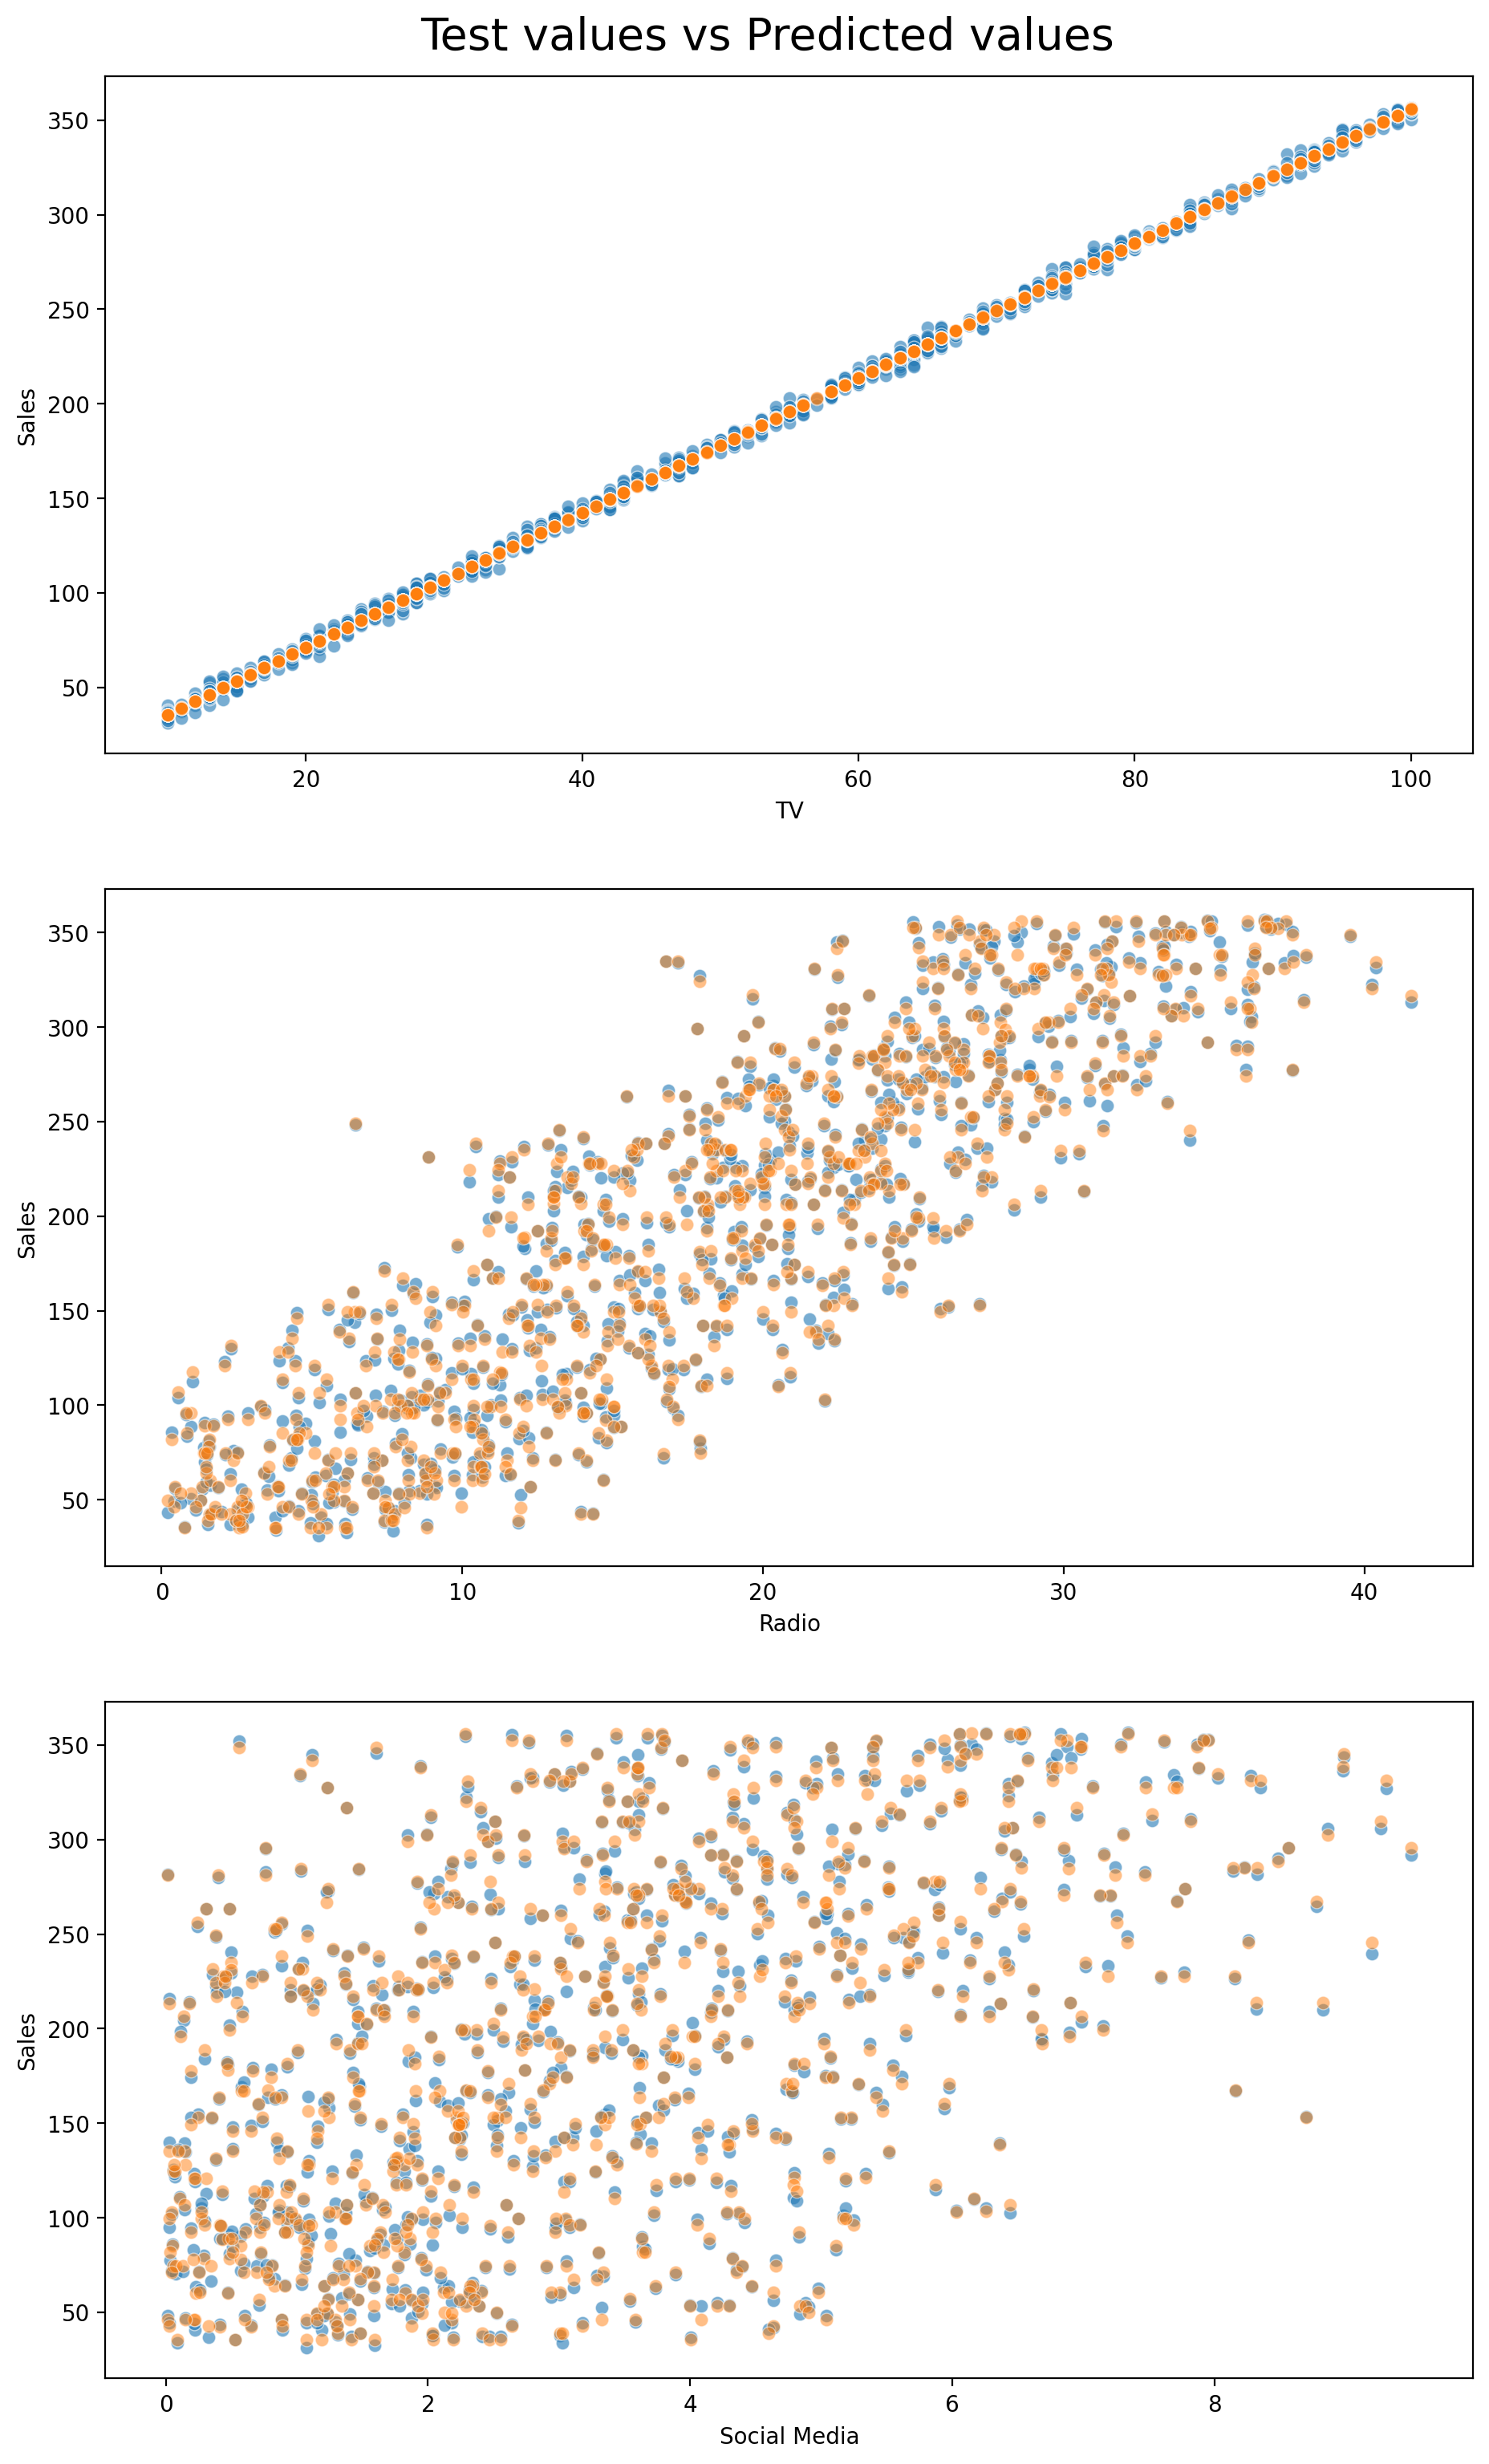

In [56]:
fig, axes = plt.subplots(3, 1, sharey=True, dpi=200, figsize=(11,19))
fig.suptitle('Test values vs Predicted values', fontsize=20, x=0.5, y=0.9)

sns.scatterplot(x=X_test['TV'], y=y_test, ax=axes[0], alpha=0.6)
sns.scatterplot(x=X_test['TV'], y=finalSVR_pred, ax=axes[0], alpha=0.5)
axes[0]

sns.scatterplot(x=X_test['Radio'], y=y_test, ax=axes[1], alpha=0.6)
sns.scatterplot(x=X_test['Radio'], y=finalSVR_pred, ax=axes[1], alpha=0.5)


sns.scatterplot(x=X_test['Social Media'], y=y_test, ax=axes[2], alpha=0.6)
sns.scatterplot(x=X_test['Social Media'], y=finalSVR_pred, ax=axes[2], alpha=0.5)

plt.show()

## Polynomial Regression model

In [57]:
X = df.drop(columns='Sales')

In [58]:
y = df['Sales']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
from sklearn.preprocessing import PolynomialFeatures

In [61]:
from sklearn.linear_model import LinearRegression

In [62]:
polynomial = PolynomialFeatures()
scaler = StandardScaler()
pca = PCA()
linReg = LinearRegression()

pipeline = Pipeline([('polynomial', polynomial),
                     ('scaler', scaler),
                     ('pca', pca),
                     ('linReg', linReg)])

In [63]:
pipe_params = {'polynomial__include_bias': [True, False],
               'polynomial__degree': [2, 3, 4],
               'pca__n_components': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]}

In [64]:
Polynomial_model = GridSearchCV(pipeline,
                         pipe_params,
                         scoring='neg_mean_squared_error',
                         cv=5,
                         verbose=3)

In [65]:
Polynomial_model.fit(X_train, y_train)

Fitting 5 folds for each of 78 candidates, totalling 390 fits
[CV 1/5] END pca__n_components=2, polynomial__degree=2, polynomial__include_bias=True;, score=-1863.040 total time=   0.0s
[CV 2/5] END pca__n_components=2, polynomial__degree=2, polynomial__include_bias=True;, score=-1685.576 total time=   0.0s
[CV 3/5] END pca__n_components=2, polynomial__degree=2, polynomial__include_bias=True;, score=-1872.595 total time=   0.0s
[CV 4/5] END pca__n_components=2, polynomial__degree=2, polynomial__include_bias=True;, score=-1719.170 total time=   0.0s
[CV 5/5] END pca__n_components=2, polynomial__degree=2, polynomial__include_bias=True;, score=-1915.183 total time=   0.0s
[CV 1/5] END pca__n_components=2, polynomial__degree=2, polynomial__include_bias=False;, score=-1863.040 total time=   0.0s
[CV 2/5] END pca__n_components=2, polynomial__degree=2, polynomial__include_bias=False;, score=-1685.576 total time=   0.0s
[CV 3/5] END pca__n_components=2, polynomial__degree=2, polynomial__include

[CV 4/5] END pca__n_components=4, polynomial__degree=2, polynomial__include_bias=False;, score=-147.584 total time=   0.0s
[CV 5/5] END pca__n_components=4, polynomial__degree=2, polynomial__include_bias=False;, score=-146.617 total time=   0.0s
[CV 1/5] END pca__n_components=4, polynomial__degree=3, polynomial__include_bias=True;, score=-468.897 total time=   0.0s
[CV 2/5] END pca__n_components=4, polynomial__degree=3, polynomial__include_bias=True;, score=-447.346 total time=   0.0s
[CV 3/5] END pca__n_components=4, polynomial__degree=3, polynomial__include_bias=True;, score=-459.007 total time=   0.0s
[CV 4/5] END pca__n_components=4, polynomial__degree=3, polynomial__include_bias=True;, score=-460.532 total time=   0.0s
[CV 5/5] END pca__n_components=4, polynomial__degree=3, polynomial__include_bias=True;, score=-461.226 total time=   0.0s
[CV 1/5] END pca__n_components=4, polynomial__degree=3, polynomial__include_bias=False;, score=-468.897 total time=   0.0s
[CV 2/5] END pca__n_c

[CV 1/5] END pca__n_components=6, polynomial__degree=4, polynomial__include_bias=True;, score=-529.228 total time=   0.0s
[CV 2/5] END pca__n_components=6, polynomial__degree=4, polynomial__include_bias=True;, score=-508.118 total time=   0.0s
[CV 3/5] END pca__n_components=6, polynomial__degree=4, polynomial__include_bias=True;, score=-503.439 total time=   0.0s
[CV 4/5] END pca__n_components=6, polynomial__degree=4, polynomial__include_bias=True;, score=-511.613 total time=   0.0s
[CV 5/5] END pca__n_components=6, polynomial__degree=4, polynomial__include_bias=True;, score=-552.970 total time=   0.0s
[CV 1/5] END pca__n_components=6, polynomial__degree=4, polynomial__include_bias=False;, score=-529.228 total time=   0.0s
[CV 2/5] END pca__n_components=6, polynomial__degree=4, polynomial__include_bias=False;, score=-508.118 total time=   0.0s
[CV 3/5] END pca__n_components=6, polynomial__degree=4, polynomial__include_bias=False;, score=-503.439 total time=   0.0s
[CV 4/5] END pca__n_c

[CV 2/5] END pca__n_components=9, polynomial__degree=2, polynomial__include_bias=True;, score=-38.597 total time=   0.0s
[CV 3/5] END pca__n_components=9, polynomial__degree=2, polynomial__include_bias=True;, score=-41.468 total time=   0.0s
[CV 4/5] END pca__n_components=9, polynomial__degree=2, polynomial__include_bias=True;, score=-44.264 total time=   0.0s
[CV 5/5] END pca__n_components=9, polynomial__degree=2, polynomial__include_bias=True;, score=-39.780 total time=   0.0s
[CV 1/5] END pca__n_components=9, polynomial__degree=2, polynomial__include_bias=False;, score=-42.121 total time=   0.0s
[CV 2/5] END pca__n_components=9, polynomial__degree=2, polynomial__include_bias=False;, score=-38.597 total time=   0.0s
[CV 3/5] END pca__n_components=9, polynomial__degree=2, polynomial__include_bias=False;, score=-41.468 total time=   0.0s
[CV 4/5] END pca__n_components=9, polynomial__degree=2, polynomial__include_bias=False;, score=-44.264 total time=   0.0s
[CV 5/5] END pca__n_componen

[CV 5/5] END pca__n_components=11, polynomial__degree=2, polynomial__include_bias=False;, score=-26.247 total time=   0.0s
[CV 1/5] END pca__n_components=11, polynomial__degree=3, polynomial__include_bias=True;, score=-64.598 total time=   0.0s
[CV 2/5] END pca__n_components=11, polynomial__degree=3, polynomial__include_bias=True;, score=-67.525 total time=   0.0s
[CV 3/5] END pca__n_components=11, polynomial__degree=3, polynomial__include_bias=True;, score=-67.294 total time=   0.0s
[CV 4/5] END pca__n_components=11, polynomial__degree=3, polynomial__include_bias=True;, score=-67.752 total time=   0.0s
[CV 5/5] END pca__n_components=11, polynomial__degree=3, polynomial__include_bias=True;, score=-69.251 total time=   0.0s
[CV 1/5] END pca__n_components=11, polynomial__degree=3, polynomial__include_bias=False;, score=-64.598 total time=   0.0s
[CV 2/5] END pca__n_components=11, polynomial__degree=3, polynomial__include_bias=False;, score=-67.525 total time=   0.0s
[CV 3/5] END pca__n_c

[CV 3/5] END pca__n_components=13, polynomial__degree=3, polynomial__include_bias=False;, score=-10.574 total time=   0.0s
[CV 4/5] END pca__n_components=13, polynomial__degree=3, polynomial__include_bias=False;, score=-11.425 total time=   0.0s
[CV 5/5] END pca__n_components=13, polynomial__degree=3, polynomial__include_bias=False;, score=-11.663 total time=   0.0s
[CV 1/5] END pca__n_components=13, polynomial__degree=4, polynomial__include_bias=True;, score=-95.799 total time=   0.0s
[CV 2/5] END pca__n_components=13, polynomial__degree=4, polynomial__include_bias=True;, score=-100.923 total time=   0.0s
[CV 3/5] END pca__n_components=13, polynomial__degree=4, polynomial__include_bias=True;, score=-95.509 total time=   0.0s
[CV 4/5] END pca__n_components=13, polynomial__degree=4, polynomial__include_bias=True;, score=-101.562 total time=   0.0s
[CV 5/5] END pca__n_components=13, polynomial__degree=4, polynomial__include_bias=True;, score=-108.216 total time=   0.0s
[CV 1/5] END pca__

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('polynomial', PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('linReg', LinearRegression())]),
             param_grid={'pca__n_components': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14],
                         'polynomial__degree': [2, 3, 4],
                         'polynomial__include_bias': [True, False]},
             scoring='neg_mean_squared_error', verbose=3)

In [66]:
Poly_cv_results = pd.DataFrame(Polynomial_model.cv_results_)
Poly_cv_results[['param_polynomial__include_bias',
                 'param_polynomial__degree',
                 'param_pca__n_components', 
                 'mean_test_score']].sort_values(by='mean_test_score', ascending=False)

,param_polynomial__include_bias,param_polynomial__degree,param_pca__n_components,mean_test_score
72,True,2,14,-8.768079
73,False,2,14,-8.768079
67,False,2,13,-8.817102
66,True,2,13,-8.817102
75,False,3,14,-11.441894
...,...,...,...,...
0,True,2,2,-1811.112974
3,False,3,2,-2418.013081
2,True,3,2,-2418.013081
5,False,4,2,-3094.317238


In [67]:
Poly_pred = Polynomial_model.predict(X_test)

In [68]:
RMSE = np.sqrt(mean_squared_error(y_test, Poly_pred))
R2 = r2_score(y_test, Poly_pred)
print(f'RMSE: {RMSE}')
print(f'R^2: {R2}')

RMSE: 2.9403501874920717
R^2: 0.9990097415023673


In [69]:
liczba_pc = Polynomial_model.best_estimator_.named_steps.pca.n_components_

In [70]:
explained = pd.DataFrame(Polynomial_model.best_estimator_.named_steps.pca.explained_variance_ratio_, columns=['Explained_ratio'])

In [71]:
explained['Cumulative'] = explained['Explained_ratio'].cumsum()
explained

,Explained_ratio,Cumulative
0,0.628592,0.628592
1,0.205990,0.834582
2,0.111118,0.945699
3,0.024439,0.970138
4,0.012438,0.982576
5,0.005664,0.988240
6,0.004604,0.992844
7,0.002078,0.994922
8,0.001752,0.996674
9,0.001259,0.997933


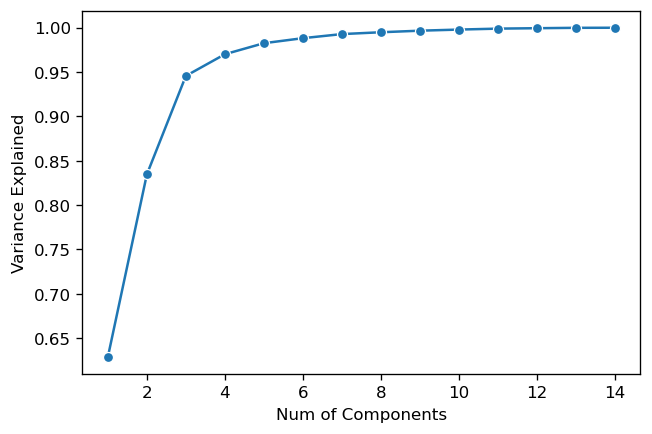

In [72]:
plt.figure(dpi=120)
sns.lineplot(x=np.arange(1, liczba_pc+1), y=explained['Cumulative'], marker='o')
plt.ylabel('Variance Explained')
plt.xlabel('Num of Components')
plt.show()